## Analyzing trends in real-estate with Zillow Home Value Index (ZHVI)

In [7]:
import pandas as pd

# Link to Zillow Home Value Index (ZHVI) dataset
URL = 'http://files.zillowstatic.com/research/public_v2/zhvi/Zip_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_mon.csv'

df = pd.read_csv(URL)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30421 entries, 0 to 30420
Columns: 303 entries, RegionID to 2020-06-30
dtypes: float64(294), int64(3), object(6)
memory usage: 70.3+ MB


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,...,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1528565.0,1528783.0,1532013.0,1528340.0,1535262.0,1537467.0,1548305.0,1539673.0,1531246.0,1511876.0,1501002.0,1496032.0,1487739.0,1479655.0,1470063.0,1463490.0,1459408.0,1453692.0,1452616.0,1457732.0,1458667.0,1457951.0,1442745.0,1427877.0,1414763.0,1411065.0,1409411.0,1412290.0,1408443.0,1409344.0,1397980.0,1389522.0,1383244.0,1380903.0,1385338.0,1386299.0,1385537.0,1377219.0,1366529.0,1351955.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,362440.0,361714.0,361161.0,360524.0,359230.0,358914.0,358239.0,359372.0,361117.0,364129.0,367590.0,370336.0,374274.0,377567.0,381500.0,383071.0,386448.0,386742.0,387560.0,385479.0,383137.0,379123.0,375309.0,373963.0,372395.0,372573.0,372492.0,375526.0,378230.0,384007.0,390161.0,...,948578.0,951425.0,953370.0,952458.0,950828.0,952362.0,955128.0,954800.0,951856.0,952186.0,957625.0,962903.0,961953.0,961589.0,962566.0,966273.0,966707.0,966503.0,966801.0,969217.0,972674.0,975231.0,973282.0,970077.0,968228.0,967829.0,967991.0,967588.0,969195.0,970063.0,969701.0,968746.0,967546.0,966119.0,965833.0,966867.0,968066.0,967947.0,966726.0,964844.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1737834.0,1727541.0,1726229.0,1723586.0,1726729.0,1730852.0,1735167.0,1723771.0,1711089.0,1694564.0,1684564.0,1686200.0,1692036.0,1698891.0,1701484.0,1704615.0,1710300.0,1711359.0,1708966.0,1708031.0,1706030.0,1703261.0,1689338.0,1675134.0,1664479.0,1657341.0,1651324.0,1637561.0,1622242.0,1607607.0,1597185.0,1590668.0,1584963.0,1581334.0,1584746.0,1586066.0,1582635.0,1575709.0,1569296.0,1569607.0
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,200594.0,200842.0,200645.0,199456.0,198318.0,197652.0,198416.0,198104.0,197450.0,196660.0,197562.0,199247.0,201807.0,203051.0,204328.0,206536.0,208994.0,210707.0,210375.0,212520.0,215032.0,217238.0,216305.0,214595.0,211862.0,210250.0,208544.0,207604.0,206565.0,206155.0,206048.0,...,332456.0,332521.0,331455.0,331175.0,331459.0,331598.0,331404.0,331413.0,331457.0,332404.0,333391.0,333701.0,333476.0,333839.0,334758.0,335483.0,335387.0,335729.0,336031.0,336409.0,336825.0,336667.0,337064.0,337103.0,337174.0,336317.0,335653.0,335492.0,336028.0,336202.0,336361.0,336399.0,336382.0,336475.0,336202.0,336398.0,336859.0,337928.0,338853.0,339429.0
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,544060.0,543629.0,542853.0,542794.0,540480.0,540497.0,539797.0,542658.0,545532.0,550028.0,555135.0,559561.0,563748.0,566946.0,570678.0,572662.0,578798.0,581534.0,584954.0,583167.0,581151.0,578229.0,575487.0,575600.0,577945.0,582738.0,588841.0,595107.0,601879.0,608789.0,617636.0,...,1176601.0,1182176.0,1186672.0,1187482.0,1185966.0,1187343.0,1191632.0,1194001.0,1193956.0,1197010.0,1203373.0,1207601.0,1204145.0,120

In [195]:
df[df.City=='Nokomis']

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,...,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30
4070,73075,4107,34275,Zip,FL,FL,Nokomis,North Port-Sarasota-Bradenton,Sarasota County,157774.0,157635.0,157620.0,157229.0,157040.0,156791.0,156707.0,156398.0,156241.0,156221.0,156480.0,156573.0,156976.0,157443.0,158096.0,159077.0,159844.0,160761.0,161535.0,162661.0,163547.0,164186.0,164566.0,165353.0,166152.0,166776.0,166960.0,166819.0,166989.0,167265.0,167936.0,...,338347.0,338196.0,338682.0,339671.0,340904.0,341910.0,341237.0,340501.0,340086.0,340358.0,340025.0,340169.0,340940.0,342080.0,342739.0,342800.0,341673.0,342276.0,343799.0,346227.0,346571.0,346407.0,346734.0,347257.0,347035.0,346314.0,345642.0,346796.0,348856.0,349871.0,350219.0,350210.0,351544.0,353045.0,354540.0,355894.0,357547.0,359171.0,360925.0,361531.0
15317,85307,15591,62075,Zip,IL,IL,Nokomis,NaN,Montgomery County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32288.0,32530.0,32757.0,33196.0,33708.0,34105.0,34244.0,34060.0,33604.0,33163.0,32811.0,...,54522.0,54770.0,54930.0,54984.0,55002.0,55164.0,55341.0,55496.0,55658.0,55866.0,56158.0,56323.0,56529.0,56671.0,56955.0,57250.0,57585.0,57813.0,58027.0,58329.0,58628.0,58966.0,59096.0,59295.0,59392.0,59507.0,59711.0,59938.0,60206.0,60323.0,60458.0,60549.0,60633.0,60653.0,60755.0,60840.0,60939.0,61020.0,60946.0,60839.0


In [89]:
date_cols = df.columns[9:] # Columns containing dates
data = df[date_cols].dropna() # Drop rows/columns contraining null entries
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13222 entries, 1 to 30411
Columns: 294 entries, 1996-01-31 to 2020-06-30
dtypes: float64(294)
memory usage: 29.8 MB


,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,...,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30
1,362440.0,361714.0,361161.0,360524.0,359230.0,358914.0,358239.0,359372.0,361117.0,364129.0,367590.0,370336.0,374274.0,377567.0,381500.0,383071.0,386448.0,386742.0,387560.0,385479.0,383137.0,379123.0,375309.0,373963.0,372395.0,372573.0,372492.0,375526.0,378230.0,384007.0,390161.0,397602.0,405315.0,414026.0,422230.0,429215.0,434025.0,438186.0,441495.0,444744.0,...,948578.0,951425.0,953370.0,952458.0,950828.0,952362.0,955128.0,954800.0,951856.0,952186.0,957625.0,962903.0,961953.0,961589.0,962566.0,966273.0,966707.0,966503.0,966801.0,969217.0,972674.0,975231.0,973282.0,970077.0,968228.0,967829.0,967991.0,967588.0,969195.0,970063.0,969701.0,968746.0,967546.0,966119.0,965833.0,966867.0,968066.0,967947.0,966726.0,964844.0
3,200594.0,200842.0,200645.0,199456.0,198318.0,197652.0,198416.0,198104.0,197450.0,196660.0,197562.0,199247.0,201807.0,203051.0,204328.0,206536.0,208994.0,210707.0,210375.0,212520.0,215032.0,217238.0,216305.0,214595.0,211862.0,210250.0,208544.0,207604.0,206565.0,206155.0,206048.0,204769.0,204254.0,204721.0,206348.0,207207.0,207753.0,208467.0,209718.0,210547.0,...,332456.0,332521.0,331455.0,331175.0,331459.0,331598.0,331404.0,331413.0,331457.0,332404.0,333391.0,333701.0,333476.0,333839.0,334758.0,335483.0,335387.0,335729.0,336031.0,336409.0,336825.0,336667.0,337064.0,337103.0,337174.0,336317.0,335653.0,335492.0,336028.0,336202.0,336361.0,336399.0,336382.0,336475.0,336202.0,336398.0,336859.0,337928.0,338853.0,339429.0
4,544060.0,543629.0,542853.0,542794.0,540480.0,540497.0,539797.0,542658.0,545532.0,550028.0,555135.0,559561.0,563748.0,566946.0,570678.0,572662.0,578798.0,581534.0,584954.0,583167.0,581151.0,578229.0,575487.0,575600.0,577945.0,582738.0,588841.0,595107.0,601879.0,608789.0,617636.0,627533.0,640286.0,651467.0,662468.0,671610.0,678219.0,683496.0,687360.0,693425.0,...,1176601.0,1182176.0,1186672.0,1187482.0,1185966.0,1187343.0,1191632.0,1194001.0,1193956.0,1197010.0,1203373.0,1207601.0,1204145.0,1201334.0,1201132.0,1202696.0,1202887.0,1202712.0,1203956.0,1205905.0,1209151.0,1210550.0,1207290.0,1202853.0,1201631.0,1201695.0,1202719.0,1201694.0,1202704.0,1202295.0,1200264.0,1198154.0,1195523.0,1193421.0,1193009.0,1194815.0,1196093.0,1196435.0,1195008.0,1194721.0
5,97404.0,97396.0,97354.0,97374.0,97369.0,97340.0,97296.0,97370.0,97504.0,97509.0,97554.0,97638.0,97426.0,97146.0,96887.0,97021.0,97160.0,97397.0,97583.0,97630.0,97635.0,97865.0,98234.0,98506.0,99096.0,99571.0,100058.0,99924.0,99905.0,99793.0,99842.0,99897.0,100036.0,100214.0,100051.0,99923.0,99955.0,100503.0,101244.0,101898.0,...,169555.0,170297.0,170625.0,170937.0,171008.0,171318.0,171789.0,172532.0,173007.0,173395.0,173882.0,174421.0,174906.0,175875.0,176845.0,177738.0,178236.0,178934.0,179798.0,180525.0,180888.0,181327.0,182336.0,183291.0,183608.0,183263.0,183411.0,184184.0,185302.0,186069.0,186563.0,187124.0,187972.0,188804.0,189240.0,189718.0,190715.0,191943.0,192873.0,193366.0
7,97855.0,97879.0,97804.0,97796.0,97754.0,97735.0,97606.0,97561.0,97584.0,97618.0,97654.0,97678.0,97367.0,96950.0,96609.0,96566.0,96580.0,96569.0,96665.0,96677.0,96676.0,96733.0,96939.0,97147.0,97748.0,98

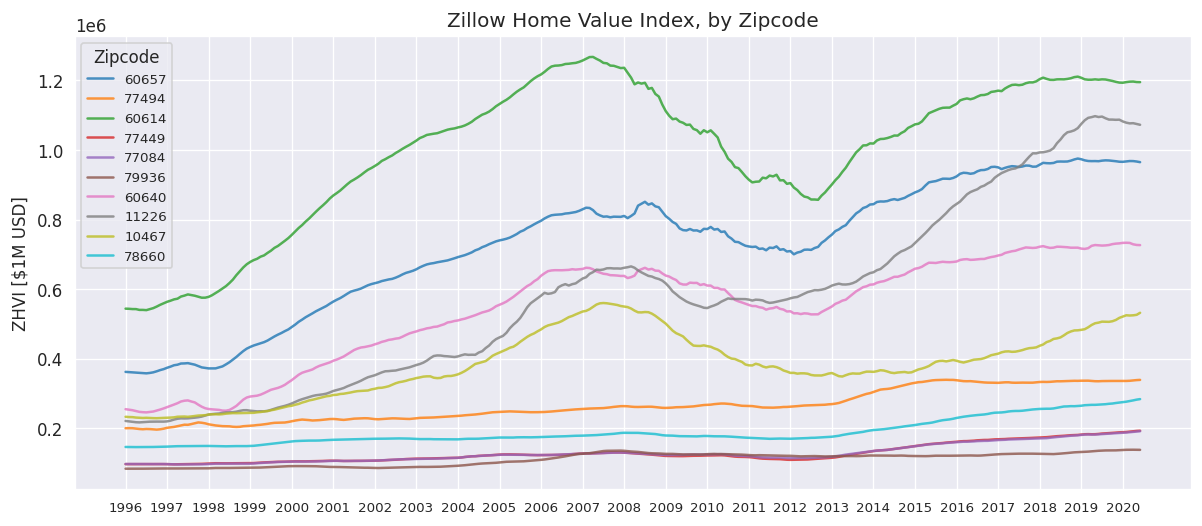

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')



zipcodes = df.iloc[data.index,2].values


plt.figure(figsize=(12,5),dpi=120)

for i,zip in enumerate(zipcodes[:10]):

    series = data.iloc[i,:].values
    plt.plot(series, label=str(zip), alpha=.8)


plt.title("Zillow Home Value Index, by Zipcode")

plt.xticks(range(0,300,12), 
           labels=range(1996,2021),
           fontsize=8)
plt.ylabel("ZHVI [$1M USD]")

plt.legend(title="Zipcode",fontsize=8)
plt.show()

## What homes have fallen in value over the past year?

In [222]:
import numpy as np


def plot_top_k(k=10,m=24,trend='growth',metric='amount'):
    """
    this function visualizes the top k growers/losers
    """
    current_value = data.iloc[:,-1].values 
    previous_value = data.iloc[:,-m].values
    value_change =  current_value - previous_value
    
    if metric=='percent':
        value_change = value_change / previous_value

    if trend=='growth':
        indices = value_change.argsort()[-k:][::-1]
        top = data.iloc[indices,:].values

    elif trend=='loss':
        indices = value_change.argsort()[:k]
        top = data.iloc[indices,:].values
    else:
        return "Improper trend"

    metric_char={'amount':'$','percent':'%'}.get(metric)

    plt.figure(figsize=(12,5),dpi=120)
    plt.title(f"Top {trend} Zipcodes (by {metric}) from June '18 to June '20)")

    for i,ind in enumerate(indices):

        city = df.iloc[ind,6]
        state = df.iloc[ind,5]
        zip = df.iloc[ind,2]

        if metric=="percent":
            change = value_change[ind]
            label = str(zip) + ", " + city + ', ' + state + ", {0:.2f}%".format(change)
        else:
            change = str(int(value_change[ind]))
            change = change[:-3] + ',' + change[-3:]
            label = str(zip) + ", " + city + ', ' + state + ", " + change

        plt.plot(top[i,-24:],label=label)

    legend_title = f"Zip, City, State, {trend} [{metric_char}]"
    plt.legend(title=legend_title,fontsize=8)

    plt.xticks(range(0,30,6),
            labels=[df.columns[-25+j*6] for j in range(5)])
    
    plt.ylabel("ZHVI [$1M USD]")
    plt.show()

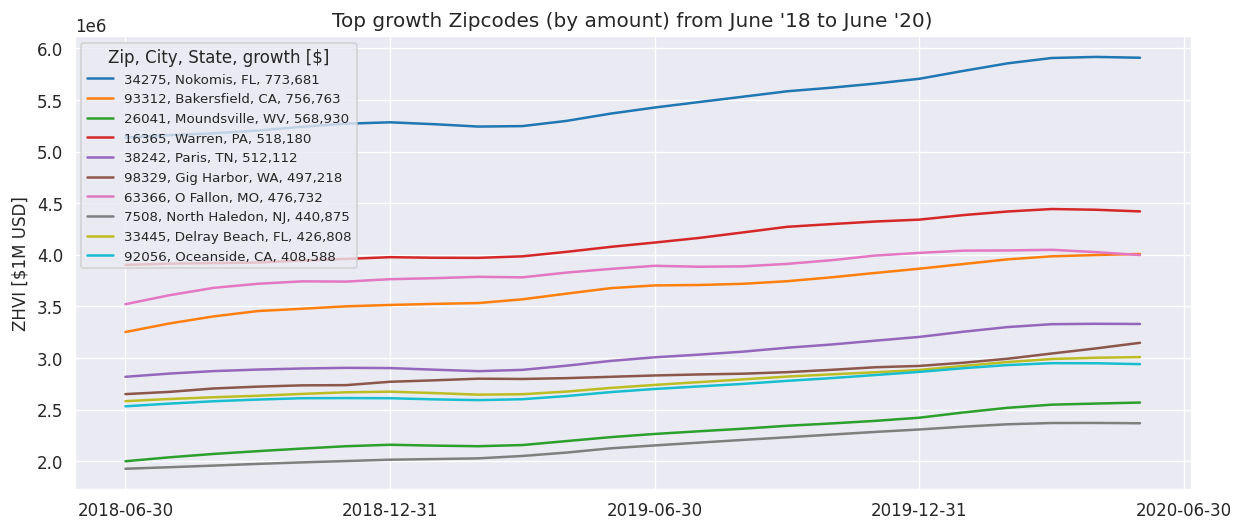

In [224]:
plot_top_k(trend="growth",metric="amount")

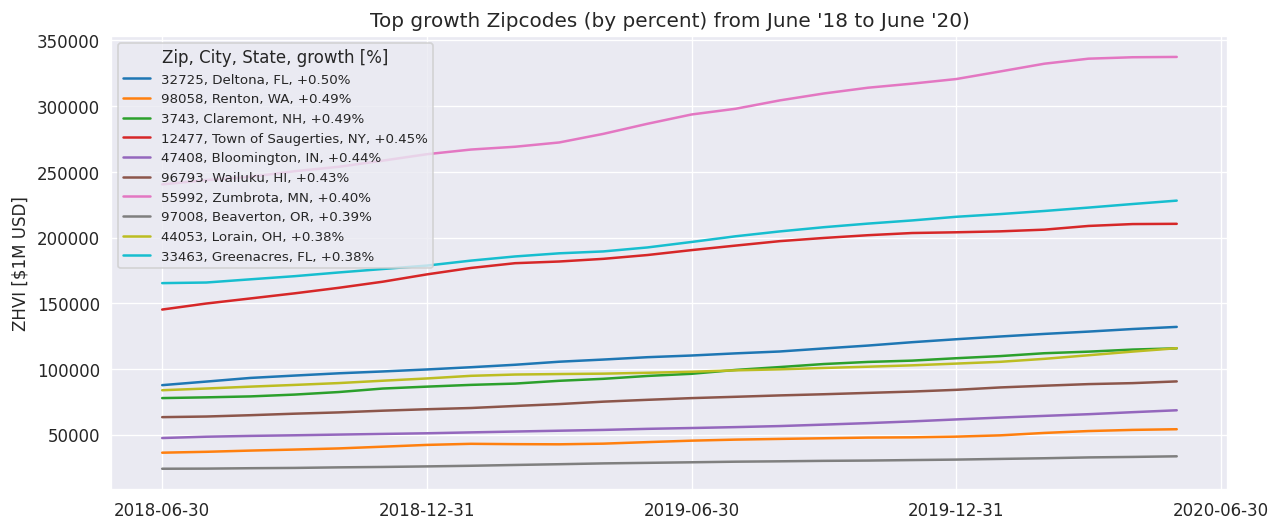

In [223]:
plot_top_k(trend="growth",metric="percent")

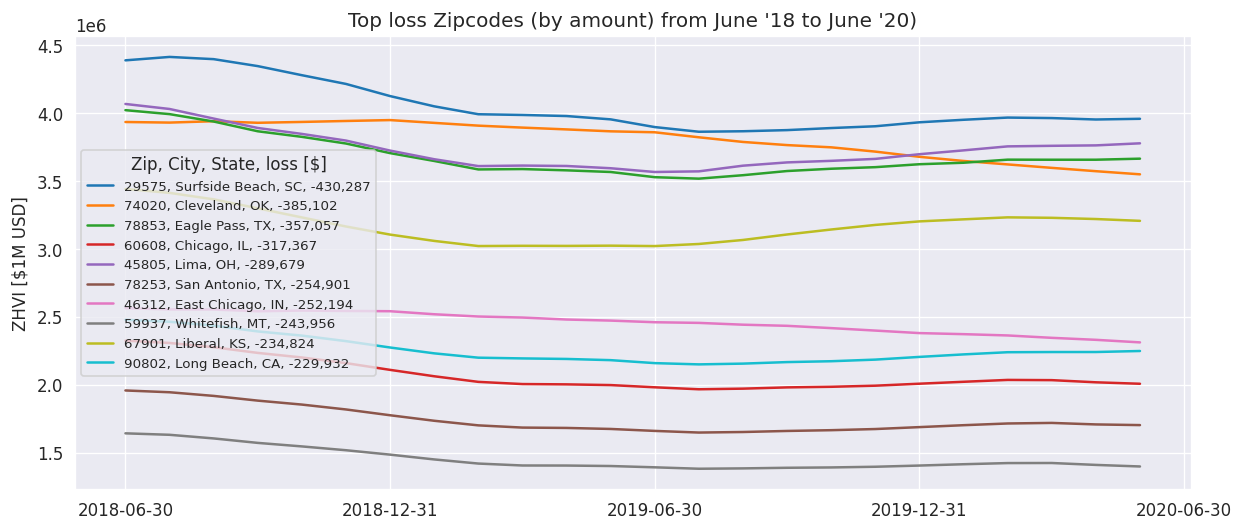

In [225]:
plot_top_k(trend="loss",metric="amount")

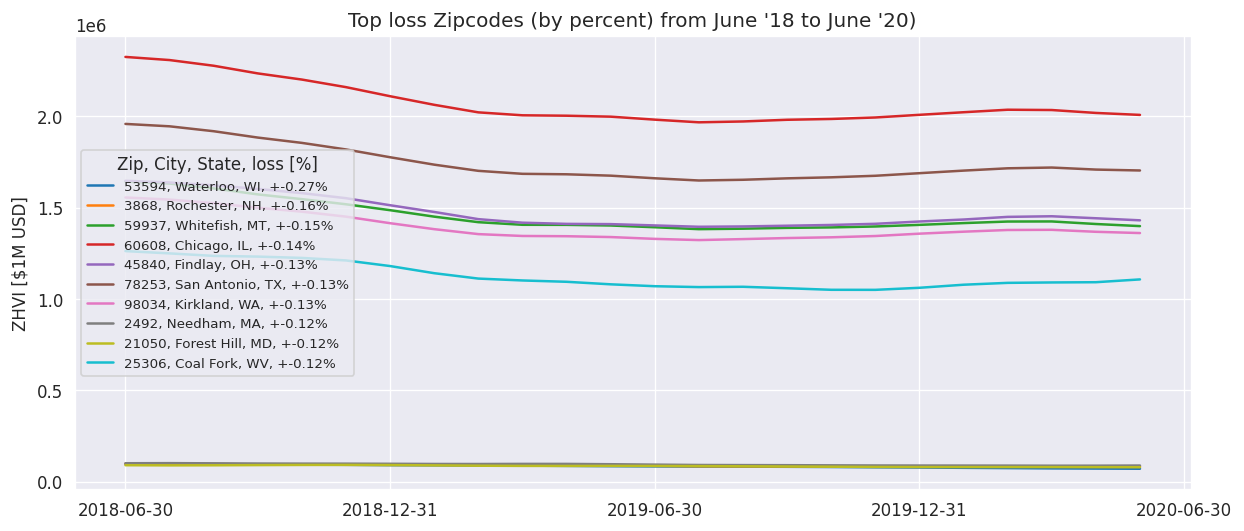

In [226]:
plot_top_k(trend="loss",metric="percent")

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.data.experimental import AUTOTUNE
"""
### Turn each signal into a labeled dataset
"""
window_size = 30   # num. days per training sample
batch_size = 16   # num. of samples per epoch
split_time = 1400  # where to split the data for training/validation
buffer_size = 1000 # num of samples in memory for random selection

def window_dataset(series, window=window_size, batch=batch_size, buffer=buffer_size):
    """Funtion to turn time series data into set of sequences 
    where the last value is the intended output of our model"""
    ser = tf.expand_dims(series, axis=-1)
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(window + 1, shift=1, drop_remainder=True)
    data = data.flat_map(lambda x: x.batch(window + 1))
    data = data.shuffle(buffer)
    data = data.map(lambda x: (x[:-1], x[1:]),num_parallel_calls=AUTOTUNE)
    return data.batch(batch).prefetch(AUTOTUNE)


# Uncomment lines blow for univariate time series data
# x_train = X[:split_time]
# x_test = X[split_time:]

# Uncomment lines below for multivariate time series data
x_train = X[:split_time,:]
x_test = X[split_time:,:]

print(f"Training data shape: {x_train.shape}")
print(f"Validation data shape: {x_test.shape}")

ds_train = window_dataset(x_train)

In [ ]:
import
help()

In [ ]:
keras.backend.clear_session()

"""
### Choose and connect the model components   
"""
# 1D convolution layers
conv1 = layers.Conv1D(
    filters=60,kernel_size=15,strides=1,
    padding="causal",activation="relu",
    input_shape=[None,len(features)])

conv2 = layers.Conv1D(
    filters=60,kernel_size=5,strides=1,
    padding="causal",activation="tanh")

# Bidirectional LSTM layers
lstm1 = layers.Bidirectional(layers.LSTM(30,return_sequences=True))
lstm2 = layers.Bidirectional(layers.LSTM(20,return_sequences=True))

# Model construction
inputs = layers.Input(shape=(None,len(features)))
x = conv1(inputs)
x = lstm1(x)
x = lstm2(x)
x = conv2(x)
x = layers.Dense(60,activation='relu')(x)
x = layers.Dropout(.1)(x)
x = layers.Dense(1,activation='tanh')(x)
outputs = layers.Lambda(lambda x: 25*abs(x))(x)

# SGD optimizer and Huber loss
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
loss = keras.losses.Huber()

model = keras.Model(inputs=inputs,outputs=outputs)
model.compile(optimizer,loss,
              metrics=["mae"])
model.summary()